In [141]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt

In [142]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## Load the dataset

In [165]:
data = pd.read_csv("../cleaned_data_1.csv", header=0, index_col=0)
data.head(5)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,name_length,minumum_nights
0,0.0,107,0.000297,-0.000541,0.0,149,1,0.000002,0.000044,0.002668,0.999992,34,0.002740
1,0.0,126,0.000312,-0.000567,1.0,225,1,0.000003,0.000015,0.002720,0.999992,21,0.002817
2,0.0,93,0.000298,-0.000541,0.0,150,3,0.000000,0.000007,0.002669,0.999962,35,0.008219
3,0.0,41,0.000611,-0.001111,1.0,89,1,0.000070,0.000015,0.002915,0.999982,31,0.005155
4,0.0,61,0.047474,-0.086042,1.0,80,10,0.000116,0.001164,0.000000,0.000000,48,0.995159


In [144]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

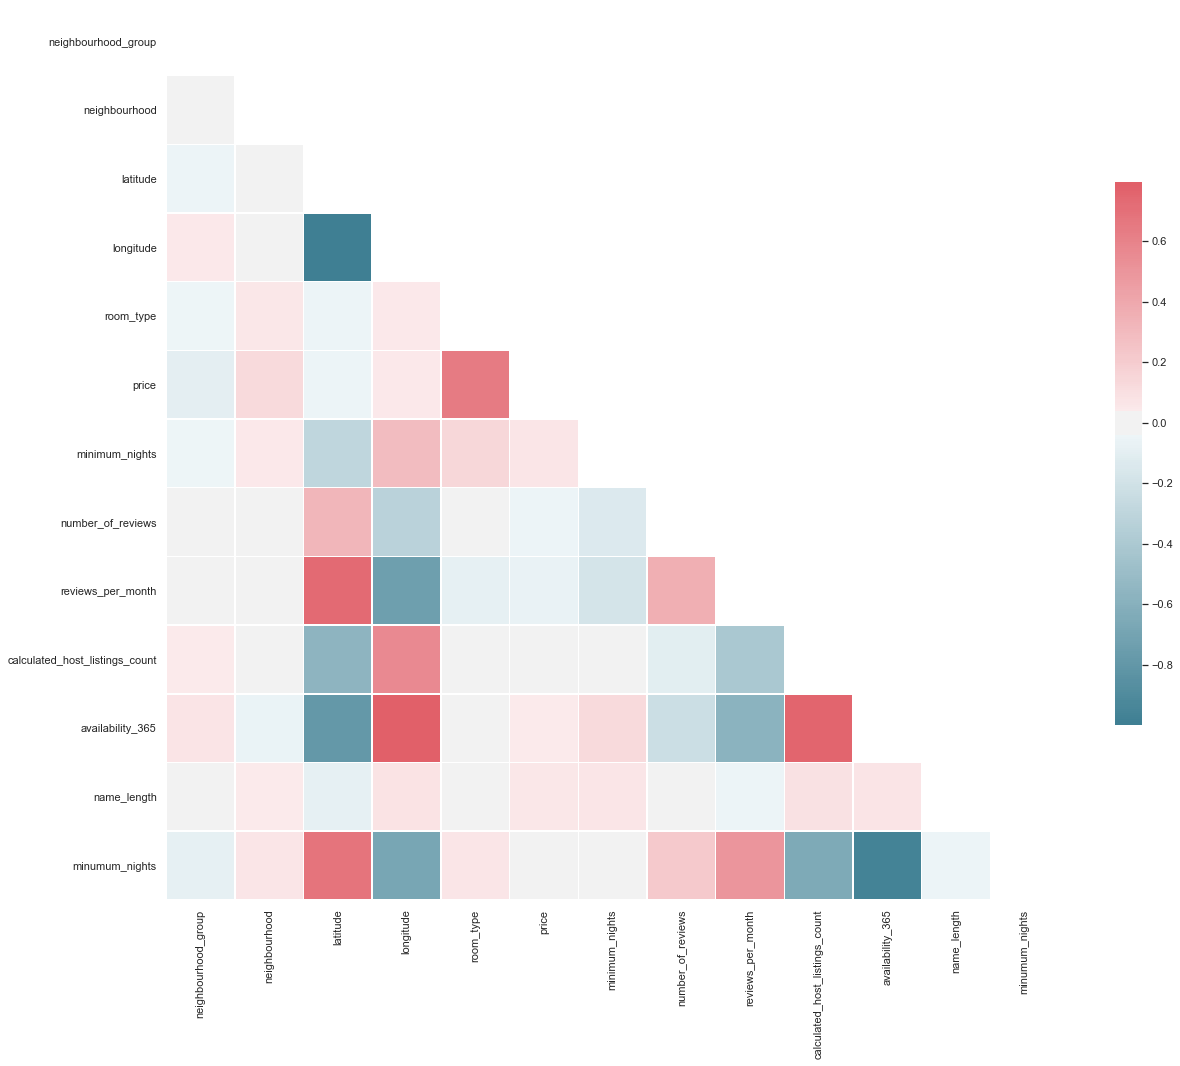

In [145]:
multi_collinearity_heatmap(data, figsize=(20,20))

In [146]:
numerical_columns = list(data.columns)
numerical_columns

['neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'name_length',
 'minumum_nights']

In [147]:
data["minimum_night"] = np.log(data["minimum_nights"] + 10**-15)
data["number_of_reviews"] = np.log(data["number_of_reviews"] + 10**-15)
data["reviews_per_month"] = np.log(data["reviews_per_month"] + 10**-15)
data["calculated_host_listings_count"] = np.log(data["calculated_host_listings_count"] + 10**-15)
data["availability_365"] = np.log(data["availability_365"] + 10**-15)
data["name_length"] = np.log(data["name_length"] + 10**-15)
data = data.sample(n=data.shape[0])

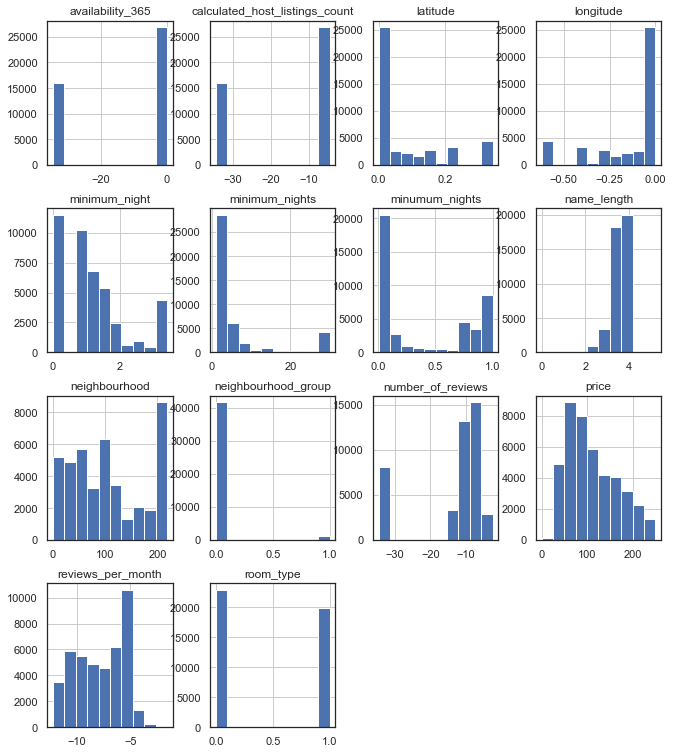

In [148]:
data.hist(figsize=(11,13));

In [149]:
# Separating X and y
X = data.drop('price', axis=1)
y = data.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))


# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Build a neural network

**Evaluation Metrics:**  
* mean squared error / root mean square error (for loss)  
* r squared (for accuracy)

### Model 1: XGBoost
A vanilla XGBoost model will be used to predict price, in order to provide a baseline level of accuracy and a measure of feature importance. This most likely provides the best achievable accuracy using machine learning models (other than possible small accuracy increases from hyper-parameter tuning) due to XGBoost's superior performance.

In [150]:
import time
from datetime import datetime
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score

In [151]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

In [152]:
print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_xgb_reg, squared=False),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_xgb_reg, squared=False),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.0 minutes

Training MSE: 903.6415
Validation MSE: 1259.7719

Training RMSE: 30.0606
Validation RMSE: 35.4933

Training r2: 0.6878
Validation r2: 0.5647


In [153]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
minimum_night,0.000000
name_length,0.008088
longitude,0.008098
latitude,0.009056
calculated_host_listings_count,0.009435
number_of_reviews,0.010578
reviews_per_month,0.010767
minumum_nights,0.012199
availability_365,0.017437
minimum_nights,0.024675


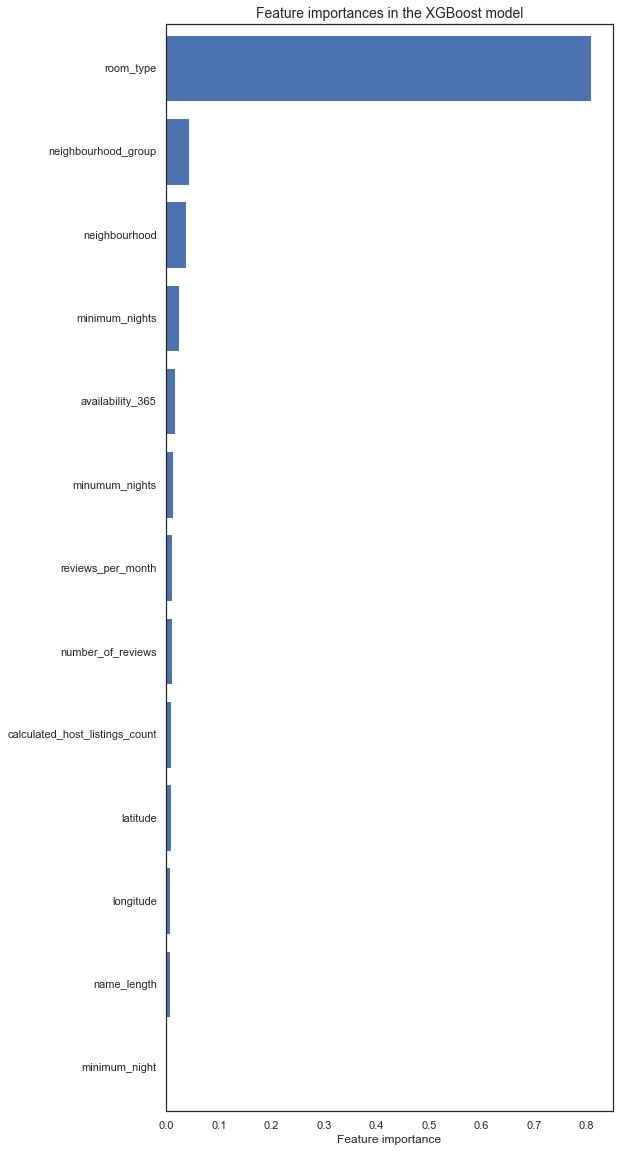

In [154]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

Those features which have an importance of less than 0.01 in this XGBoost regression model and could potentially be removed.

In [155]:
data.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'name_length', 'minumum_nights', 'minimum_night'],
      dtype='object')

**Top important features:**  
* 'room_type'
* 'neighbourhood_group'
* 'neighbourhood'
* 'minumum_nights'
* 'availability_365'

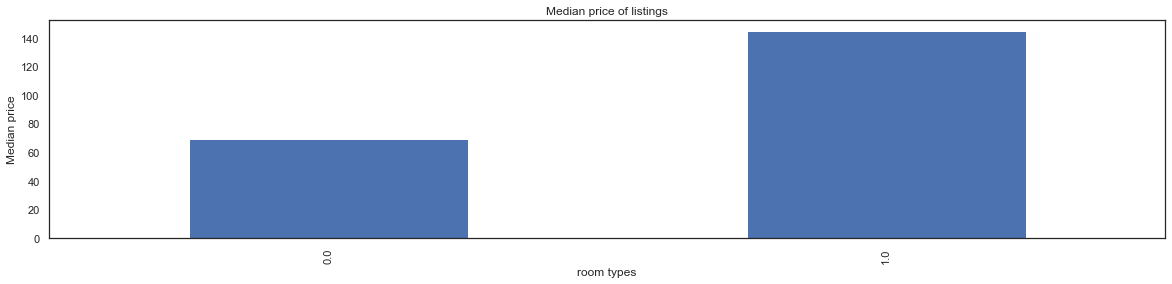

In [156]:
plt.figure()
data.groupby('room_type').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings')
plt.xlabel('room types')
plt.ylabel('Median price');

## Model 2: Neural Network with SGD optimizer

To try and reduce over-fitting, L1 regularization will be used. This acts to reduce parameter coefficients (or potentially remove them altogether by setting the coefficient to zero) in order to to reduce model complexity and overfitting.  
Unlike L2 regularization, L1 regularization performs penalised estimation and selection simultaneously, and so is preferred when the number of predictors is very high.  
An SGD (stochastic gradient descent) optimizer is used.

In [157]:
X_train.head(5)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,name_length,minumum_nights,minimum_night
42535,-0.158991,1.580704,-0.705632,0.705656,1.075216,-0.566380,0.263367,-1.262015,0.737968,0.772465,1.023161,-0.951976,-1.070789
17974,-0.158991,-0.646415,1.211926,-1.216240,1.075216,-0.449312,0.812111,1.078427,-1.298781,-1.299275,0.850340,1.225333,-0.398612
1914,-0.158991,-1.112217,-0.707136,0.707161,-0.930046,-0.332245,0.075653,-1.752344,0.723371,0.772464,0.966734,-0.940416,-0.005413
32110,-0.158991,-1.330562,2.205901,-2.208976,1.075216,-0.566380,0.907513,1.257151,-1.298781,-1.299275,-0.312010,0.840017,-1.070789
18935,-0.158991,1.406028,1.222066,-1.220030,1.075216,-0.449312,0.616435,1.079088,-1.298781,-1.299275,-1.399799,1.223875,-0.398612


In [173]:
import keras
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

In [176]:
# Building the model
nn = models.Sequential()
nn.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn.add(layers.Dense(1, activation='linear'))

# SGD optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

# Compiling the model
nn.compile(loss='mean_squared_error',
            optimizer=optimizer,
            metrics=['mean_squared_error'])

# Model summary
print(nn.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 128)               1792      
_________________________________________________________________
dense_56 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_57 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_58 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 513       
Total params: 232,705
Trainable params: 232,705
Non-trainable params: 0
_________________________________________________________________
None


In [175]:
# Training the model
nn_start = time.time()

nn_history = nn.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=256,
                  validation_split = 0.1)

nn_end = time.time()

print(f"Time taken to run: {round((nn_end - nn_start)/60,1)} minutes")

Epoch 1/50
121/121 [==============================] - 0s 3ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/50
121/121 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/50
121/121 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/50
121/121 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/50
121/121 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 6/50
121/121 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 7/50
121/121 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: 

In [166]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """
    
    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining RMSE:", round(mean_squared_error(y_train, y_train_pred, squared=False),4))
    print("Validation RMSE:", round(mean_squared_error(y_test, y_test_pred, squared=False),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

In [163]:
nn_model_evaluation(nn, skip_epochs=10) 

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').